In [1]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
from pyspark.sql import udf
from pyspark.sql import DataFrame
from pyspark.sql import Row, Column
from pyspark.sql.utils import AnalysisException
from pyspark.pandas.typedef import as_spark_type

from pyspark.ml.feature import Bucketizer

In [213]:
from typing import Tuple, Optional, Callable, Union, Any, overload
from enum import Enum, auto
from itertools import chain
from decimal import Decimal
from datetime import datetime, date
import contextlib
import sys
import math
import io
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = (
    SparkSession.builder.appName("Testes")
    .config('spark.sql.adaptive.enabled', 'true')
    .config('spark.sql.adaptive.optimizerEnabled', 'true')
    .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
    .config("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED")
    .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")
    .config("spark.sql.legacy.timeParserPolicy", "CORRECTED")
    .config("spark.sql.repl.eagerEval.enabled", "true")
    .config("spark.sql.debug.maxToStringFields", "100000")
    .enableHiveSupport()
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext

24/08/24 17:03:14 WARN Utils: Your hostname, dell resolves to a loopback address: 127.0.1.1; using 192.168.15.6 instead (on interface wlp0s20f3)
24/08/24 17:03:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/08/24 17:03:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# ChatGPT

In [4]:
# Sample DataFrames for expected (reference) and actual distributions
expected_data = [(1,), (2,), (2,), (3,), (4,), (4,), (5,), (5,), (6,), (7,)]
actual_data = [(1,), (2,), (2,), (3,), (4,), (5,), (5,), (50,), (7,), (8,)]

expected_df = spark.createDataFrame(expected_data, ["value"])
actual_df = spark.createDataFrame(actual_data, ["value"])

In [5]:
actual_df.show()

+-----+
|value|
+-----+
|    1|
|    2|
|    2|
|    3|
|    4|
|    5|
|    5|
|   50|
|    7|
|    8|
+-----+



In [6]:
# Define binning boundaries (you can adjust this based on your data)
splits = [-float("inf"), 2, 4, 6, float("inf")]

In [7]:
# Apply bucketizer to both expected and actual DataFrames
bucketizer = Bucketizer(splits=splits, inputCol="value", outputCol="bucket")
expected_binned = bucketizer.transform(expected_df)
actual_binned = bucketizer.transform(actual_df)

In [8]:
actual_binned.show()

+-----+------+
|value|bucket|
+-----+------+
|    1|   0.0|
|    2|   1.0|
|    2|   1.0|
|    3|   1.0|
|    4|   2.0|
|    5|   2.0|
|    5|   2.0|
|   50|   3.0|
|    7|   3.0|
|    8|   3.0|
+-----+------+



In [9]:
# Calculate the distribution for expected and actual
expected_distribution = expected_binned.groupBy("bucket").agg(F.count("value").alias("expected_count"))
actual_distribution = actual_binned.groupBy("bucket").agg(F.count("value").alias("actual_count"))

In [10]:
actual_distribution.show()

+------+------------+
|bucket|actual_count|
+------+------------+
|   0.0|           1|
|   1.0|           3|
|   2.0|           3|
|   3.0|           3|
+------+------------+



In [11]:
# Join expected and actual distributions on bucket
distribution = expected_distribution.join(actual_distribution, "bucket", "outer").fillna(0)

# Add columns for expected and actual percentages
total_expected = expected_df.count()
total_actual = actual_df.count()

In [12]:
distribution = distribution\
    .withColumn("expected_percent", F.col("expected_count") / total_expected)\
    .withColumn("actual_percent", F.col("actual_count") / total_actual)

In [13]:
distribution.show()

+------+--------------+------------+----------------+--------------+
|bucket|expected_count|actual_count|expected_percent|actual_percent|
+------+--------------+------------+----------------+--------------+
|   0.0|             1|           1|             0.1|           0.1|
|   1.0|             3|           3|             0.3|           0.3|
|   2.0|             4|           3|             0.4|           0.3|
|   3.0|             2|           3|             0.2|           0.3|
+------+--------------+------------+----------------+--------------+



In [14]:
# Calculate PSI
distribution = distribution.withColumn("psi_component", 
    (F.col("actual_percent") - F.col("expected_percent")) * 
    F.when(F.col("actual_percent") == 0, F.lit(0.0)).otherwise(F.log(F.col("actual_percent") / F.col("expected_percent")))
)

In [15]:
# Sum PSI components to get the final PSI value
psi_value = distribution.agg({"psi_component": "sum"}).collect()[0][0]
print(f"PSI: {psi_value}")

PSI: 0.06931471805599454


# EvidentlyAI

In [46]:
def calculate_stats(df: DataFrame, column_name: str, *funcs: Callable[[str], Column]) -> Union[Tuple, Any]:
    cols = [f(column_name).alias(str(i)) for i, f in enumerate(funcs)]
    result = df.select(cols).first()
    if result is None:
        raise ValueError("Empty DataFrame")
    if len(funcs) == 1:
        return result["0"]
    return tuple(result[str(i)] for i in range(len(funcs)))

In [47]:
def get_histogram(
    df: DataFrame,
    column_name: str,
    nbinsx: int,
    density: bool,
    *,
    dmax: Optional[float] = None,
    dmin: Optional[float] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    if dmax is None or dmin is None:
        min_val, max_val = calculate_stats(df, column_name, F.min, F.max)
        if min_val == max_val:
            min_val -= 0.5
            max_val += 0.5
    else:
        min_val, max_val = dmin, dmax
    step = (max_val - min_val) / nbinsx
    hist = (
        df.select(column_name, F.floor((F.col(column_name) - min_val) / step).alias("bucket"))
        .select(
            column_name, 
            F.when(F.col("bucket") >= nbinsx, nbinsx - 1).otherwise(F.col("bucket")).alias("bucket")
        )
        .groupby("bucket")
        .count()
    )
    hist_values = {r.bucket: r["count"] for r in hist.collect()}
    n = np.array([hist_values.get(i, 0) for i in range(nbinsx)])
    bin_edges = np.array([min_val + step * i for i in range(nbinsx + 1)])

    if density:
        db = np.array(np.diff(bin_edges), float)
        return (n / db / n.sum()).tolist(), bin_edges

    return n, bin_edges

In [48]:
def hist_bin_doane(data: DataFrame, column_name: str) -> Tuple[int, Optional[float], Optional[float]]:
    """
    Doane's histogram bin estimator.

    Improved version of Sturges' formula which works better for
    non-normal data. See
    stats.stackexchange.com/questions/55134/doanes-formula-for-histogram-binning
    """
    data = data.cache()
    size = data.count()
    if size > 2:
        sg1 = np.sqrt(6.0 * (size - 2) / ((size + 1.0) * (size + 3)))
        dmax, dmin, dmean, sigma = calculate_stats(data, column_name, F.max, F.min, F.mean, F.stddev_pop)
        if sigma > 0.0:
            g1 = calculate_stats(data, column_name, lambda x: F.mean(F.pow(((F.col(x) - dmean) / sigma), 3)))
            width = (dmax - dmin) / (1.0 + np.log2(size) + np.log2(1.0 + np.absolute(g1) / sg1))
            return int(np.ceil((dmax - dmin) / width)), dmax, dmin
    return 1, None, None

In [55]:
def get_binned_data(
    reference_data: DataFrame,
    current_data: DataFrame,
    column_name: str,
    feature_type: str,
    fill_zeroes: bool = True,
):
    """Split variable into n buckets based on reference quantiles
    Args:
        reference_data: reference data
        current_data: current data
        feature_type: feature type
        n: number of quantiles
    Returns:
        reference_percents: % of records in each bucket for reference
        current_percents: % of records in each bucket for current
    """
    # n_vals = reference_data.distinct().count()

    if feature_type == "num":  # and n_vals > 20:
        bins, dmax, dmin = hist_bin_doane(
            current_data.dropna(subset=[column_name]).union(reference_data.dropna(subset=[column_name])), column_name
        )
        print(f"Bins: {bins}  |  Dmax: {dmax}  |  Dmin: {dmin}")

        reference_percents = (
            get_histogram(reference_data, column_name=column_name, nbinsx=bins, density=False, dmax=dmax, dmin=dmin)[0]
            / reference_data.count()
        )
        current_percents = (
            get_histogram(current_data, column_name=column_name, nbinsx=bins, density=False, dmax=dmax, dmin=dmin)[0]
            / current_data.count()
        )

    else:
        ref_stats = reference_data.groupby(column_name).agg(F.count(column_name).alias("ref"))
        cur_stats = current_data.groupby(column_name).agg(F.count(column_name).alias("cur"))
        stats = ref_stats.join(cur_stats, on=column_name, how="fullouter").collect()

        reference_percents = np.array([r["ref"] or 0 for r in stats])
        reference_percents = reference_percents / reference_percents.sum()
        current_percents = np.array([r["cur"] or 0 for r in stats])
        current_percents = current_percents / current_percents.sum()

    if fill_zeroes:
        np.place(
            reference_percents,
            reference_percents == 0,
            min(reference_percents[reference_percents != 0]) / 10**6
            if min(reference_percents[reference_percents != 0]) <= 0.0001
            else 0.0001,
        )
        np.place(
            current_percents,
            current_percents == 0,
            min(current_percents[current_percents != 0]) / 10**6
            if min(current_percents[current_percents != 0]) <= 0.0001
            else 0.0001,
        )

    return reference_percents, current_percents

In [200]:
ref_data =     [(2,), (2,), (2,), (3,), (4,), (4,), (5,), (5,), (6,), (7,)]
current_data = [(2,), (2,), (2,), (3,), (3,), (4,), (5,), (5,), (7,), (8,)]

# ref_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("c",), ("d",), ("d",), ("e",), ("f",)]
# current_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("d",), ("d",), ("x",), ("f",), ("g",)]


df_ref = spark.createDataFrame(ref_data, ["value"])
df_current = spark.createDataFrame(current_data, ["value"])
column_name = "value"

In [201]:
feature_type = "num"

reference_percents, current_percents = get_binned_data(df_ref, df_current, column_name, feature_type)

Bins: 7  |  Dmax: 8  |  Dmin: 2


In [202]:
psi_values = (reference_percents - current_percents) * np.log(reference_percents / current_percents)
print(list(psi_values))

[0.0, 0.06931471805599453, 0.06931471805599453, 0.0, 0.6900847523703155, 0.0, 0.6900847523703155]


In [203]:
psi_value = np.sum(psi_values)

In [204]:
psi_value

1.5187989408526201

# Pandas 1

In [ ]:
# https://www.aporia.com/learn/data-science/practical-introduction-to-population-stability-index-psi/

In [205]:
def prepare_data_for_plotting(dev_data, val_data, col_name, num_bins=10):
    bins = np.linspace(dev_data[col_name].min(), dev_data[col_name].max(), num_bins + 1)
    print(f"Bins: {list(bins)}", end="\n\n")
    dev_data['bin'] = pd.cut(dev_data[col_name], bins=bins, include_lowest=True)
    val_data['bin'] = pd.cut(val_data[col_name], bins=bins, include_lowest=True)
    dev_group = dev_data.groupby('bin', observed=True)[col_name].count().reset_index(name='dev_count')
    val_group = val_data.groupby('bin', observed=True)[col_name].count().reset_index(name='val_count')
    # Merge dev and val counts
    merged_counts = dev_group.merge(val_group, on='bin', how='left')
    # Calculate percentages
    merged_counts['dev_pct'] = merged_counts['dev_count'] / len(dev_data) * 100
    merged_counts['val_pct'] = merged_counts['val_count'] / len(val_data) * 100
    return merged_counts

In [206]:
def plot_psi(dev_data, val_data, psi_value, col_name, num_bins=10):
    plot_data = prepare_data_for_plotting(dev_data, val_data, col_name, num_bins)
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the chart size here
    index = np.arange(len(plot_data))
    bar_width = 0.35
    dev_bars = ax.bar(index, plot_data['dev_pct'], bar_width, label='Development')
    val_bars = ax.bar(index + bar_width, plot_data['val_pct'], bar_width, label='Validation')
    ax.set_xlabel('Bins')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Population Stability Index (PSI): {psi_value:.4f}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(plot_data['bin'].apply(lambda x: f"{x.left:.2f}-{x.right:.2f}"))
    ax.legend()
    fig.tight_layout()
    plt.show()

In [207]:
def population_stability_index(dev_data, val_data, col_name, num_bins=10):
    bins = np.linspace(dev_data[col_name].min(), dev_data[col_name].max(), num_bins + 1)
    print(f"Bins: {list(bins)}", end="\n\n")
    dev_data['bin'] = pd.cut(dev_data[col_name], bins=bins, include_lowest=True)
    val_data['bin'] = pd.cut(val_data[col_name], bins=bins, include_lowest=True)

    dev_group = dev_data.groupby('bin', observed=True)[col_name].count().reset_index(name='dev_count')
    val_group = val_data.groupby('bin', observed=True)[col_name].count().reset_index(name='val_count')

    merged_counts = dev_group.merge(val_group, on='bin', how='left')

    small_constant = 1e-10
    merged_counts['dev_pct'] = (merged_counts['dev_count'] / len(dev_data)) + small_constant
    merged_counts['val_pct'] = (merged_counts['val_count'] / len(val_data)) + small_constant
    merged_counts['psi'] = (merged_counts['val_pct'] - merged_counts['dev_pct']) * np.log(merged_counts['val_pct'] / merged_counts['dev_pct'])

    return merged_counts['psi'].sum()

In [208]:
ref_data =     [(2,), (2,), (2,), (3,), (4,), (4,), (5,), (5,), (6,), (7,)]
current_data = [(2,), (2,), (2,), (3,), (3,), (4,), (5,), (5,), (7,), (8,)]

# ref_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("c",), ("d",), ("d",), ("e",), ("f",)]
# current_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("d",), ("d",), ("x",), ("f",), ("g",)]


df_ref = pd.DataFrame(ref_data, columns=["value"])
df_current = pd.DataFrame(current_data, columns=["value"])
column_name = "value"
n_bins = 6

In [209]:
psi_value = population_stability_index(df_ref, df_current, column_name, n_bins)
print(f"PSI Value: {psi_value}")

Bins: [2.0, 2.8333333333333335, 3.666666666666667, 4.5, 5.333333333333334, 6.166666666666667, 7.0]

PSI Value: 0.13862943601198913


In [ ]:
# [0.0, 0.06931471805599453, 0.06931471805599453, 0.0, 0.6900847523703155, 0.0, 0.6900847523703155]

Bins: [2.0, 2.8333333333333335, 3.666666666666667, 4.5, 5.333333333333334, 6.166666666666667, 7.0]



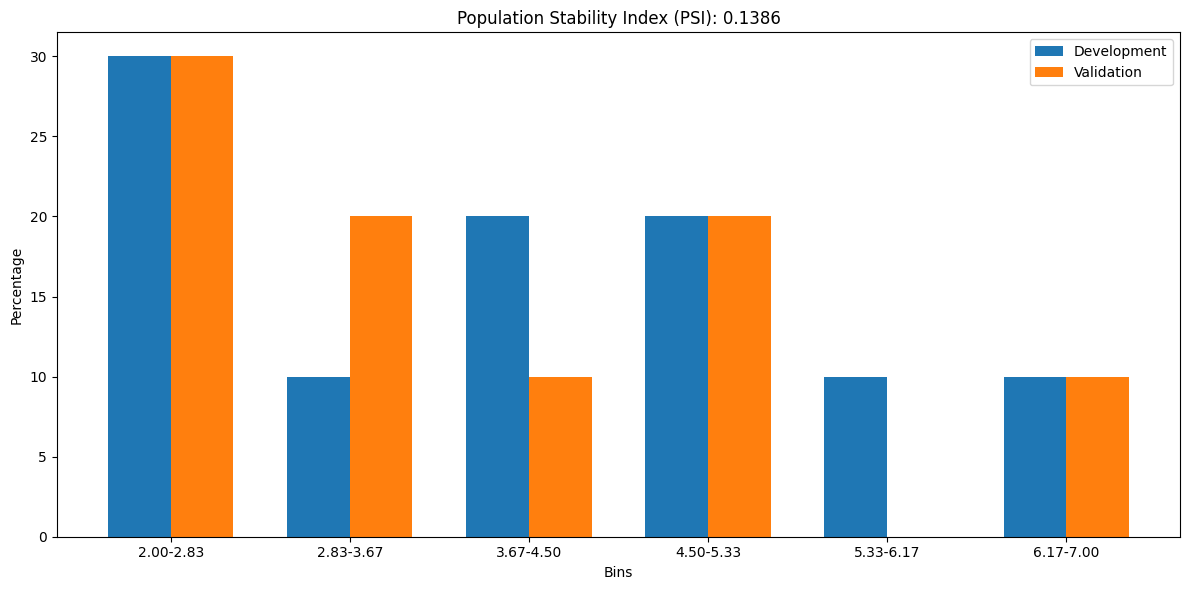

In [210]:
plot_psi(df_ref, df_current, psi_value, column_name, n_bins)

# Pandas 2

In [ ]:
# https://mwburke.github.io/data%20science/2018/04/29/population-stability-index.html
# https://github.com/mwburke/population-stability-index

In [214]:
sns.set_style("white")

In [211]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [225]:
ref_data =     [2, 2, 2, 3, 4, 4, 5, 5, 6, 7]
current_data = [2, 2, 2, 3, 3, 4, 5, 5, 7, 8]

# ref_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("c",), ("d",), ("d",), ("e",), ("f",)]
# current_data = [("a",), ("a",), ("a",), ("b",), ("c",), ("d",), ("d",), ("x",), ("f",), ("g",)]


df = pd.DataFrame({
    "ref": ref_data,
    "current": current_data
})

df_ref = df[['ref']]
df_current = df[['current']]

n_bins = 6

In [226]:
df.head()

,ref,current
0,2,2
1,2,2
2,2,2
3,3,3
4,4,3


In [219]:
df['PSI'] = (df['current'] - df['ref']) * np.log(df['current'] / df['ref'])
df.head()

,ref,current,PSI
0,2,2,0.000000
1,2,2,0.000000
2,2,2,0.000000
3,3,3,0.000000
4,4,3,0.287682


In [220]:
np.sum(df['PSI'])

0.5753641449035618

In [228]:
calculate_psi(df_ref, df_current, buckettype='quantiles', buckets=10, axis=1)

# Pandas 3

In [ ]:
# https://github.com/feature-engine/feature_engine/blob/main/feature_engine/selection/drop_psi_features.py
# https://feature-engine.trainindata.com/en/latest/api_doc/selection/DropHighPSIFeatures.html

In [ ]:
class DropHighPSIFeatures(BaseSelector):

    def __init__(
        self,
        split_col: Union[str, None] = None,
        split_frac: float = 0.5,
        split_distinct: bool = False,
        cut_off: Union[None, int, float, datetime.date, List] = None,
        switch: bool = False,
        threshold: Union[float, int, str] = 0.25,
        bins: int = 10,
        strategy: str = "equal_frequency",
        min_pct_empty_bins: float = 0.0001,
        missing_values: str = "raise",
        variables: Variables = None,
        confirm_variables: bool = False,
        p_value: float = 0.001,
    ):

        if not isinstance(split_col, (str, int, type(None))):
            raise ValueError(
                f"split_col must be a string an integer or None. Got "
                f"{split_col} instead."
            )

        # split_frac and cut_off can't be None at the same time
        if not split_frac and not cut_off:
            raise ValueError(
                f"cut_off and split_frac cannot be both set to None "
                f"The current values are {split_frac, cut_off}. Please "
                f"specify a value for at least one of these parameters."
            )

        # check split_frac only if it will be used.
        if split_frac and not cut_off:
            if not (0 < split_frac < 1):
                raise ValueError(
                    f"split_frac must be a float between 0 and 1. Got {split_frac} "
                    f"instead."
                )

        if not isinstance(split_distinct, bool):
            raise ValueError(
                f"split_distinct must be a boolean. Got {split_distinct} instead."
            )

        if not isinstance(switch, bool):
            raise ValueError(f"switch must be a boolean. Got {switch} instead.")

        if (isinstance(threshold, str) and (threshold != "auto")) or (
            isinstance(threshold, (float, int)) and threshold < 0
        ):
            raise ValueError(
                f"threshold must be greater than 0 or 'auto'. Got {threshold} instead."
            )

        if not isinstance(bins, int) or bins <= 1:
            raise ValueError(f"bins must be an integer >= 1. Got {bins} instead.")

        if strategy not in ["equal_width", "equal_frequency"]:
            raise ValueError(
                "strategy takes only values equal_width or equal_frequency. Got "
                f"{strategy} instead."
            )

        if not isinstance(min_pct_empty_bins, (float, int)) or min_pct_empty_bins < 0:
            raise ValueError(
                f"min_pct_empty_bins must be >= 0. Got {min_pct_empty_bins} "
                f"instead."
            )

        if missing_values not in ["raise", "ignore"]:
            raise ValueError(
                f"missing_values takes only values 'raise' or 'ignore'. Got "
                f"{missing_values} instead."
            )

        if isinstance(variables, list):
            if split_col in variables:
                raise ValueError(
                    f"{split_col} cannot be used to split the data and be evaluated at "
                    f"the same time. Either remove {split_col} from the variables list "
                    f"or choose another splitting criteria."
                )

        if not isinstance(p_value, float) or p_value < 0 or p_value > 1:
            raise ValueError(
                f"p_value must be a float between 0 and 1. Got {p_value} instead."
            )

        super().__init__(confirm_variables)

        # Check the variables before assignment.
        self.variables = _check_variables_input_value(variables)

        # Set all remaining arguments as attributes.
        self.split_col = split_col
        self.split_frac = split_frac
        self.split_distinct = split_distinct
        self.cut_off = cut_off
        self.switch = switch
        self.threshold = threshold
        self.bins = bins
        self.strategy = strategy
        self.min_pct_empty_bins = min_pct_empty_bins
        self.missing_values = missing_values
        self.p_value = p_value

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        """
        Find features with high PSI values.

        Parameters
        ----------
        X : pandas dataframe of shape = [n_samples, n_features]
            The training dataset.

        y : pandas series. Default = None
            y is not needed in this transformer. You can pass y or None.
        """
        # check input dataframe
        X = check_X(X)

        # select variables to evaluate
        cat_variables_, num_variables_ = self._select_variables(X)

        # check that split column is in the dataframe and remove from variable lists
        cat_variables_, num_variables_ = self._check_split_column(
            X, cat_variables_, num_variables_
        )

        if self.missing_values == "raise":
            # check if dataset contains na or inf
            _check_contains_na(X, num_variables_ + cat_variables_)
            _check_contains_inf(X, num_variables_)

        # Split the dataframe into basis and test.
        basis_df, test_df = self._split_dataframe(X)

        # Check the shape of the returned dataframes for PSI calculations.
        # The number of observations must be at least equal to the
        # number of bins.
        if min(basis_df.shape[0], test_df.shape[0]) < self.bins:
            raise ValueError(
                "The number of rows in the basis and test datasets that will be used "
                f"in the PSI calculations must be at least larger than {self.bins}. "
                "After slitting the original dataset based on the given cut_off or"
                f"split_frac we have {basis_df.shape[0]} samples in the basis set, "
                f"and {test_df.shape[0]} samples in the test set. "
                "Please adjust the value of the cut_off or split_frac."
            )

        # Switch basis and test dataframes if required.
        if self.switch:
            test_df, basis_df = basis_df, test_df

        # Set up parameters for numerical features
        if len(num_variables_) > 0:

            # Set up the discretizer for numerical features
            if self.strategy == "equal_width":
                bucketer = EqualWidthDiscretiser(bins=self.bins)
            else:
                bucketer = EqualFrequencyDiscretiser(q=self.bins)

            # Set up the threshold for numerical features
            if self.threshold == "auto":
                threshold_num = self._calculate_auto_threshold(
                    basis_df.shape[0],
                    test_df.shape[0],
                    self.bins,
                )
            else:
                threshold_num = self.threshold

        # Set up the generic threshold for categorical features if used
        if len(cat_variables_) > 0:
            if self.threshold != "auto":
                threshold_cat = self.threshold

        # Compute the PSI by looping over the features
        self.psi_values_: Dict = {}
        self.features_to_drop_ = []

        # Compute PSI for numerical features
        for feature in num_variables_:
            # Discretize feature
            basis_discrete = bucketer.fit_transform(basis_df[[feature]].dropna())
            test_discrete = bucketer.transform(test_df[[feature]].dropna())

            # Determine percentage of observations per bin
            basis_distrib, test_distrib = self._observation_frequency_per_bin(
                basis_discrete, test_discrete
            )

            # Calculate the PSI value
            self.psi_values_[feature] = np.sum(
                (test_distrib - basis_distrib) * np.log(test_distrib / basis_distrib)
            )

            # Assess if feature should be dropped
            if self.psi_values_[feature] > threshold_num:
                self.features_to_drop_.append(feature)

        # Compute the PSI for categorical features
        for feature in cat_variables_:
            basis_discrete = basis_df[[feature]]
            test_discrete = test_df[[feature]]

            # Determine percentage of observations per bin
            basis_distrib, test_distrib = self._observation_frequency_per_bin(
                basis_discrete, test_discrete
            )

            # Calculate the PSI value
            self.psi_values_[feature] = np.sum(
                (test_distrib - basis_distrib) * np.log(test_distrib / basis_distrib)
            )

            # Determine the appropriate threshold for the categorical feature
            if self.threshold == "auto":
                n_bins_cat = X[feature].nunique()
                threshold_cat = self._calculate_auto_threshold(
                    basis_df.shape[0],
                    test_df.shape[0],
                    n_bins_cat,
                )

            # Assess if feature should be dropped
            if self.psi_values_[feature] > threshold_cat:
                self.features_to_drop_.append(feature)

        # store analyzed variables
        self.variables_ = num_variables_ + cat_variables_
        # save input features
        self._get_feature_names_in(X)

        return self

    def _select_variables(self, X: pd.DataFrame):
        """Based on the user input to the `variables` attribute in init, find the
        numerical and categorical variables for which the PSI should be calculated.

        If `None`, select all numerical variables.
        If `"all", select all numerical and categorical variables.
        If string, int, or list, split into lists of numerical or categorical variables.
        """

        if self.variables is None:
            num_variables = find_numerical_variables(X)
            cat_variables: List[Union[str, int]] = []

        elif self.variables == "all":
            (
                cat_variables,
                num_variables,
            ) = find_categorical_and_numerical_variables(X, None)

        else:
            if self.confirm_variables is True:
                variables = retain_variables_if_in_df(X, self.variables)
            else:
                variables = self.variables

            (
                cat_variables,
                num_variables,
            ) = find_categorical_and_numerical_variables(X, variables)

        return cat_variables, num_variables

    def _check_split_column(
        self,
        X: pd.DataFrame,
        cat_variables: List[Union[str, int]],
        num_variables: List[Union[str, int]],
    ):
        """Check that split_col is in the dataframe and remove from numerical and
        categorical variable lists if necessary.

        It will get added if the variables are selected automatically.
        """
        if self.split_col is not None:
            # check that split_col is in the dataframe.
            if self.split_col not in X.columns:
                raise ValueError(f"{self.split_col} is not in the dataframe.")

            # Remove the split_col from variables lists. Happens when variables are
            # selected automatically by the transformer.
            if self.variables is None or self.variables == "all":
                if self.split_col in num_variables:
                    num_variables.remove(self.split_col)
                elif self.split_col in cat_variables:
                    cat_variables.remove(self.split_col)

        return cat_variables, num_variables

    def _observation_frequency_per_bin(self, basis, test):
        """
        Obtain the fraction of observations per interval.

        Parameters
        ----------
        basis : pd.DataFrame.
            The basis Pandas DataFrame with discretised (i.e., binned) values.

        test: pd.DataFrame.
            The test Pandas DataFrame with discretised (i.e., binned) values.

        Returns
        -------
        distribution.basis: pd.Series.
            Basis Pandas Series with percentage of observations per bin.

        distribution.meas: pd.Series.
            Test Pandas Series with percentage of observations per bin.
        """
        # Compute the feature distribution for basis and test
        basis_distrib = basis.value_counts(normalize=True)
        test_distrib = test.value_counts(normalize=True)

        # Align the two distributions by merging the buckets (bins). This ensures
        # the number of bins is the same for the two distributions (in case of
        # empty buckets).
        distributions = (
            pd.DataFrame(basis_distrib)
            .merge(
                pd.DataFrame(test_distrib),
                right_index=True,
                left_index=True,
                how="outer",
            )
            .fillna(self.min_pct_empty_bins)
            .replace(to_replace=0, value=self.min_pct_empty_bins)
        )
        distributions.columns = ["basis", "test"]

        return distributions.basis, distributions.test

    def _split_dataframe(self, X: pd.DataFrame):
        """
        Split dataframe according to a cut-off value and return two dataframes: the
        basis dataframe contains all observations <= cut_off and the test dataframe the
        observations > cut_off.

        If cut-off is a list, then the basis dataframe will contain all observations
        which values are within the list, and the test dataframe all remaining
        observations.

        The cut-off value is associated to a specific column.

        Parameters
        ----------
        X : pandas dataframe

        Returns
        -------
        basis_df: pd.DataFrame
            pandas dataframe with observations which value <= cut_off

        test_df: pd.DataFrame
            pandas dataframe with observations which value > cut_off
        """

        # Identify the values according to which the split must be done.
        if self.split_col is None:
            reference = pd.Series(X.index)
        else:
            reference = X[self.split_col]

        # Raise an error if there are missing values in the reference column.
        if reference.isna().any():
            raise ValueError(
                f"There are {reference.isna().sum()} missing values in the reference"
                "variable. Missing data are not allowed in the variable used to "
                "split the dataframe."
            )

        # If cut_off is not pre-defined, compute it.
        if not self.cut_off:
            self.cut_off_ = self._get_cut_off_value(reference)
        else:
            self.cut_off_ = self.cut_off

        # Split the original dataframe
        if isinstance(self.cut_off_, list):
            is_within_cut_off = np.array(reference.isin(self.cut_off_))

        else:
            is_within_cut_off = np.array(reference <= self.cut_off_)

        basis_df = X[is_within_cut_off]
        test_df = X[~is_within_cut_off]

        return basis_df, test_df

    def _get_cut_off_value(self, split_column):
        """
        Find the cut-off value to split the dataframe. It is implemented when the user
        does not enter a cut_off value as a parameter. It is calculated based on
        split_frac.

        Finds the value in a pandas series at which we find the split_frac percentage
        of observations.

        If the reference column is numerical, the cut-off value is determined using
        np.quantile. Otherwise, the cut-off value is based on the value_counts:

            - The distinct values are sorted and the cumulative sum is
            used to compute the quantile. The value with the quantile that
            is the closest to the chosen split fraction is used as cut-off.

            - The procedure assumes that categorical values are sorted alphabetically
            and cut accordingly.

        Parameters
        ----------
        split_column: pd.Series.
            Series for which the nth quantile will be computed.

        Returns
        -------
        cut_off: (float, int, str, object).
            value for the cut-off.
        """

        # In case split_distinct is used, extract series with unique values
        if self.split_distinct:
            split_column = pd.Series(split_column.unique())

        # If the value is numerical, use numpy functionality
        if is_numeric_dtype(split_column):
            cut_off = np.quantile(split_column, self.split_frac)

        # Otherwise use value_counts combined with cumsum
        else:
            reference = pd.DataFrame(
                split_column.value_counts(normalize=True).sort_index().cumsum()
            )

            # Get the index (i.e. value) with the quantile that is the closest
            # to the split_frac defined at initialization.
            distance = abs(reference - self.split_frac)
            cut_off = (distance.idxmin()).values[0]

        return cut_off

    def _calculate_auto_threshold(self, N, M, bins):
        """Threshold computation for chi-square test.

        The threshold is given by:

            threshold = χ2(q,B−1) × (1/N + 1/M)

        where:

        q = quantile of the distribution (or 1 - p-value),
        B = number of bins/categories,
        N = size of basis dataset,
        M = size of test dataset.
        See formula (5.2) from reference [1] in the class docstring.

        Parameters
        ----------
        N: float or int
        M: float or int
        bins: int

        Returns
        -------
        float
        """
        return stats.chi2.ppf(1 - self.p_value, bins - 1) * (1.0 / N + 1.0 / M)

    def _more_tags(self):
        tags_dict = _return_tags()
        tags_dict["variables"] = "pass"
        # add additional test that fails
        tags_dict["_xfail_checks"]["check_estimators_nan_inf"] = "transformer allows NA"

        return tags_dict